In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
import tools
from analysis_tools import check_data

from tools.FV3_tools import read_solo_fields
from tools.WRF_tools import read_wrf_fields
from tools.CM1_tools import read_cm1_fields

import pickle
from tools.cbook import pickle2Obj

_nthreads = 2

# edges = np.array([0, 0.01, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 6.0, 8.0, 10.0, 12.0])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
def label_panels(axs, panel_labels, fontsize=14, adjust_loc=None):

    from operator import add

    base_loc = [0.025, 0.975]

    if adjust_loc:
        loc = list(map(add, base_loc, adjust_loc)) 
    else:
        loc = base_loc

    for i, ax in enumerate(axs.flatten()):
    # Add the panel label
        ax.text(*loc, panel_labels[i], transform=ax.transAxes, fontsize=fontsize, fontweight='medium', va='top', ha='left')

    return axs


In [62]:
def precip_histogram(models, label, label2, chunk_size=4, axs=None, ylim=None, debug=False):

    import matplotlib.ticker as ticker

    if axs==None:
        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))
    else:
        ax = axs
    
    label_bins = [2**i for i in range(9)]

    label_bins = np.array(label_bins)

    label_xlim = 0.5*(label_bins[0:-1] + label_bins[1:])

    # if debug:  print(bins)

    

    # xlim = 0.5*(bins[0:-1] + bins[1:])

    # if debug:  print(xlim)

    bins = np.arange(0,257,2)
    
    xlim = 0.5*(bins[0:-1] + bins[1:])

    all_data = []
    colors = []
    labels = []
                
    for key in models.keys():

        inv = models[key][label]['accum_prec'][::-1]

        if key == 'cm1':  # CM1 has data a the zero time
            
            precip_dt = inv[0:-1] - inv[1:]

        elif key == 'rk2':  # CM1 has data a the zero time
            break
            
        else:

            add_zero_time = np.zeros(inv.shape[1:])

            precip_dt = inv[0:-1] - inv[1:]

            precip_dt = np.insert(precip_dt, 1, add_zero_time, axis=0)

        precip_hour = [sum(precip_dt[i:i + chunk_size]) for i in range(0, len(precip_dt), chunk_size)]

        precip_dt = np.array(precip_hour)
        
        # flatten data into "chunk" 
    
        data_flat = precip_dt.flatten()
        data_zero = data_flat[data_flat > 1.e-1]

       # get rid of zeros...
        
        # all_data.append(data_flat)

        hist, bins = np.histogram(data_zero, bins=bins)

        if key == 'euler':
            colors.append('red')
            labels.append('Solo')
            ax.semilogy(xlim, hist, color='r', linewidth=2.0, label=f"SOLO-FV3 Total Accum: {data_zero.sum()/10:.0f} cm")

        if key == 'rk2':
            colors.append('blue')
            labels.append('Solo-RK2')
            ax.semilogy(xlim, hist, color='b', linewidth=2.0, label=f"SOLO-RK2 Total Accum: {data_zero.sum()/10:.0f} cm")

        if key == 'cm1':
            colors.append('black')
            labels.append('CM1')
            ax.semilogy(xlim, hist, color='k', linewidth=2.0, label=f"CM1 Total Accum: {data_zero.sum()/10:.0f} cm")

    ax.set_xscale("log", base=2.0)
    
    xlabels = [f'{x:2d}' for x in label_bins[:-1]]
    
    ax.set_xticks(label_xlim, xlabels)

    ax.grid(axis='y', alpha=0.75)
    ax.grid(axis='x', alpha=0.75)
    
    ax.set_xlabel('Accumulation (mm)',fontsize=12)
    ax.set_ylabel('Frequency (No. of Grid Points across 6 hours)',fontsize=12)
    legend = ax.legend(loc='upper right', shadow=True, fontsize='medium')     
    ax.set_title(f"{label2}", loc='left', fontsize=12)

    if ylim != None:  ax.set_ylim(ylim)

    if axs==None:
        plt.suptitle("Histogram_1HR_Precipitation")
        file_label = label2.replace(" ","_")
        plt.savefig(f"Histogram_1HR_Precipitation_{file_label2}.png")
        plt.show()

    return ax

In [15]:
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity

def precip_KDE(models, label, label2, all_times=False, KDE=False):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))
    
    if all_times:
        xlim = [0.01, 300.]
            
    else:
        xlim = [0.01, 80.]
    
    for key in models.keys():
        
        if all_times:
            
            precip_dt = models[key][label]['accum_prec']
            
        else:
    
        # first, compute the increments in time of precip
    
            inv = models[key][label]['accum_prec'][::-1]
    
            precip_dt = inv[0:-1] - inv[1:]

            # for n in np.arange(6):
            #     m = n * 4
            #     precip_hour = precip_dt[m] + precip_dt[m+1] +precip_dt[m+2] +precip_dt[m+3]

            # precip_dt = precip_hour
        
        # get rid of zeros...
    
        data_flat =precip_dt.flatten()
        
        data_no_zero = data_flat[data_flat >= 0.1e0]

        hist, bin_edges = np.histogram(data_no_zero)

        # print(bin_edges)

        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges), num=100)
        # kde_sp      = gaussian_kde(data_no_zero, bw_method='silverman')
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.3)

        # kde    = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data_no_zero)
        y_sp   = kde_sp.pdf(eval_points)

        if key == 'euler':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='SOLO-FV3 (%d)' % data_no_zero.shape)

        if key == 'rk3':
            ax.plot(eval_points, y_sp, color='g', linewidth=2.0, label='SOLO-RK3 (%d)' % data_no_zero.shape)

        if key == 'rk2':
            ax.plot(eval_points, y_sp, color='b', linewidth=2.0, label='SOLO-RK2 (%d)' % data_no_zero.shape)

        if key == 'cm1':
            ax.plot(eval_points, y_sp, color='k', linewidth=2.0, label='CM1 (%d)' % data_no_zero.shape)
     
        ax.set_yscale("log")
        ax.set_xscale("log", base=2.0)
        plt.grid(axis='y', alpha=0.75)
        plt.grid(axis='x', alpha=0.75)
        ax.set_xlabel('mm',fontsize=15)
        ax.set_ylabel('Density',fontsize=15)
        legend = ax.legend(loc='lower left', shadow=True, fontsize='x-large')
        ax.set_xlim(0.5, 300. )
   
        if all_times:
            ax.axvline(x=100.0, color='k', linestyle='--', linewidth=2.0)
            ax.axvline(x=150.0, color='k', linestyle='--', linewidth=2.0)
            ax.set_title("KDE for Total Accum Precipitation:  %s" % (label2), fontsize=15)
            plt.savefig("KDE_Total_Accumulated_Precipitation_%s.png" % (label2))
        else:
            ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
            ax.axvline(x=20.0, color='k', linestyle='--', linewidth=2.0)
            ax.set_title("KDE for 15min Precipitation: %s" % (label2), fontsize=15)
            plt.savefig("KDE_15min_Precipitation_Experiment_%s.png" % (label2))

    plt.show()
    


In [4]:
cm1_3km    = '/work/wicker/CAM_analysis_tools/ideal_cases/precip/squall_3km.pkl'
euler_3km  = '/work/wicker/CAM_analysis_tools/ideal_cases/precip/euler_3km.pkl'
euler_1km  = '/work/wicker/CAM_analysis_tools/ideal_cases/precip/euler_1km.pkl'
cm1_1km    = '/work/wicker/CAM_analysis_tools/ideal_cases/precip/squall_1km.pkl'

rk2_3km    = '/work/wicker/CAM_analysis_tools/ideal_cases/precip/rk2_3km.pkl'
rk2_1km    = '/work/wicker/CAM_analysis_tools/ideal_cases/precip/rk2_1km.pkl'

In [29]:
models3km = {}

models3km['cm1']   = pickle2Obj(cm1_3km,retObj=False)
models3km['euler'] = pickle2Obj(euler_3km,retObj=False)
#models3km['rk2']   = pickle2Obj(rk2_3km,retObj=False)

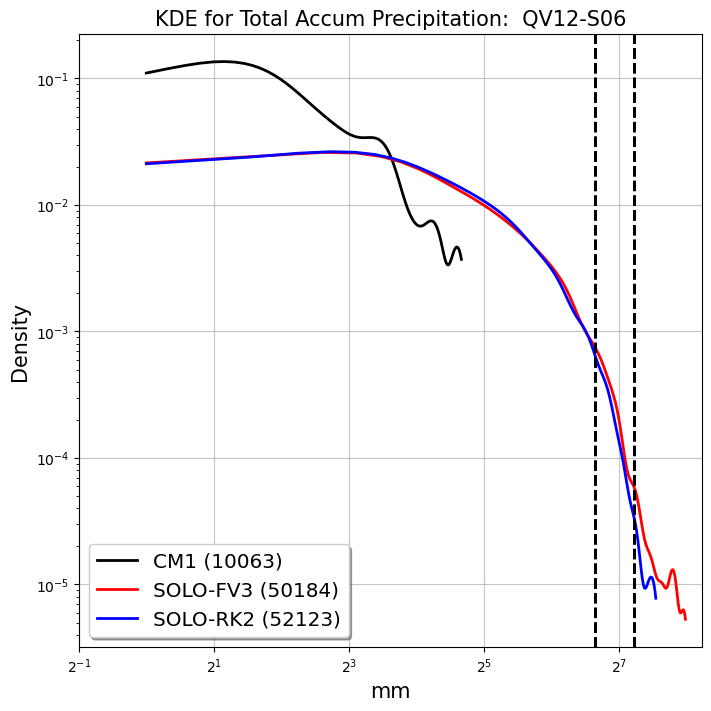

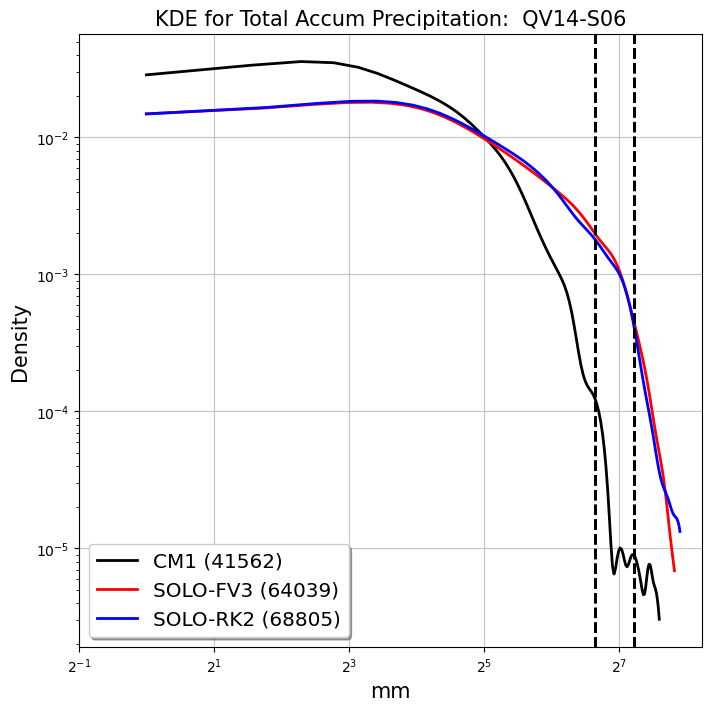

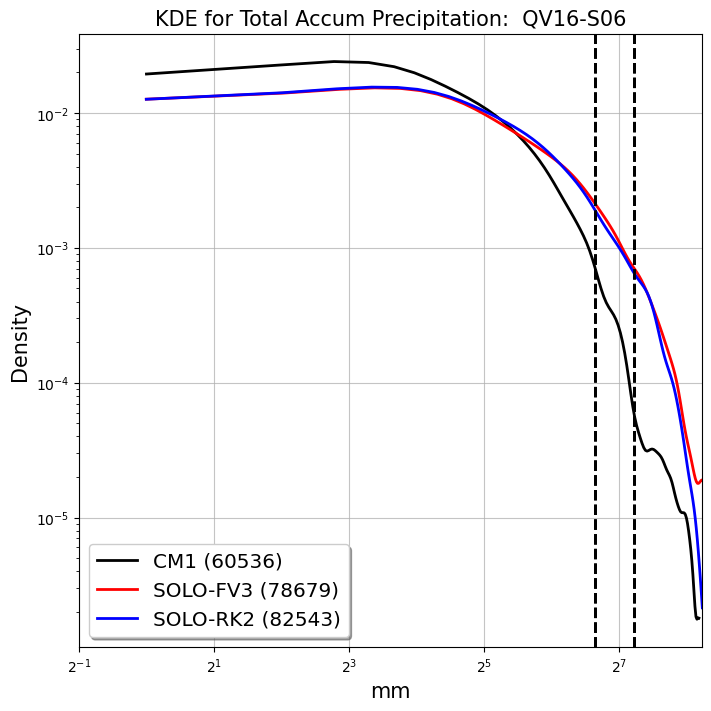

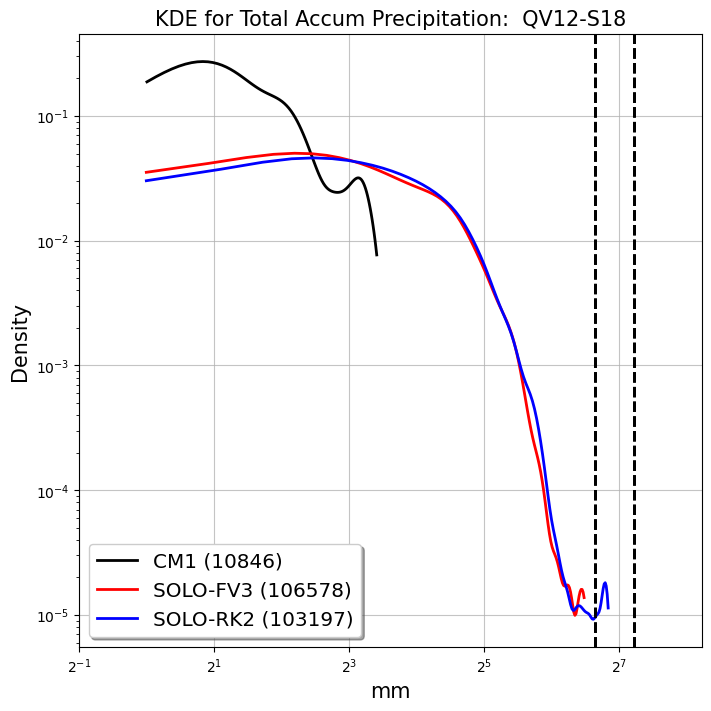

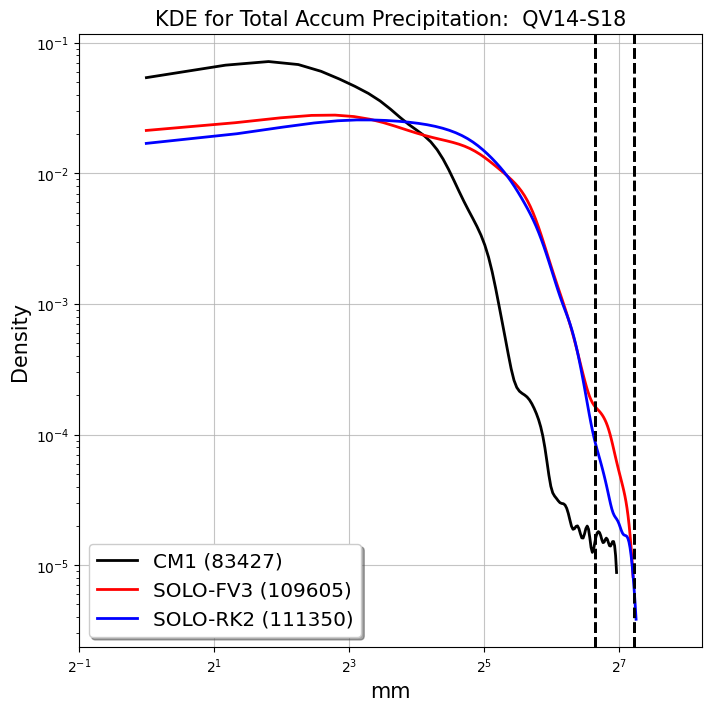

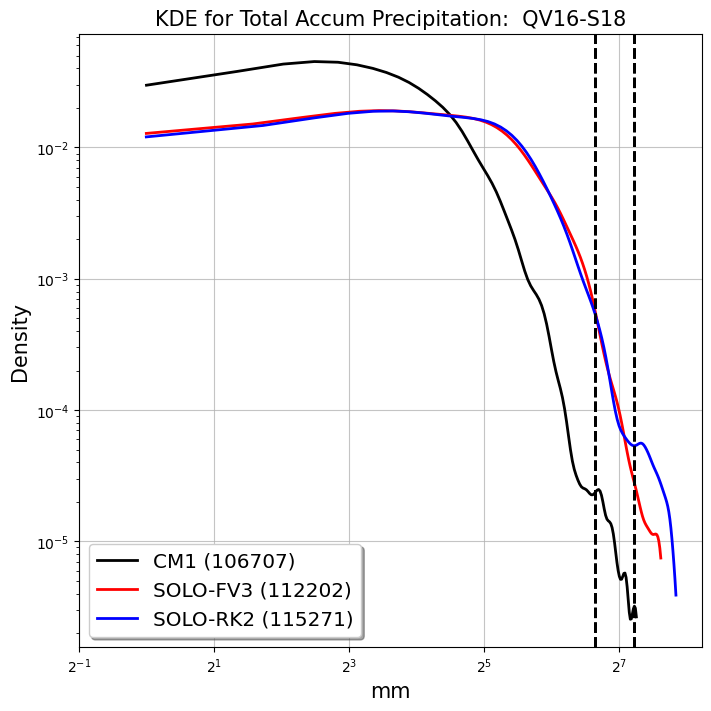

In [5]:
precip_KDE(models3km, 'QV12/S06', 'QV12-S06', all_times = True, KDE=True)
precip_KDE(models3km, 'QV14/S06', 'QV14-S06', all_times = True, KDE=True)
precip_KDE(models3km, 'QV16/S06', 'QV16-S06', all_times = True, KDE=True)
precip_KDE(models3km, 'QV12/S18', 'QV12-S18', all_times = True, KDE=True)
precip_KDE(models3km, 'QV14/S18', 'QV14-S18', all_times = True, KDE=True)
precip_KDE(models3km, 'QV16/S18', 'QV16-S18', all_times = True, KDE=True)

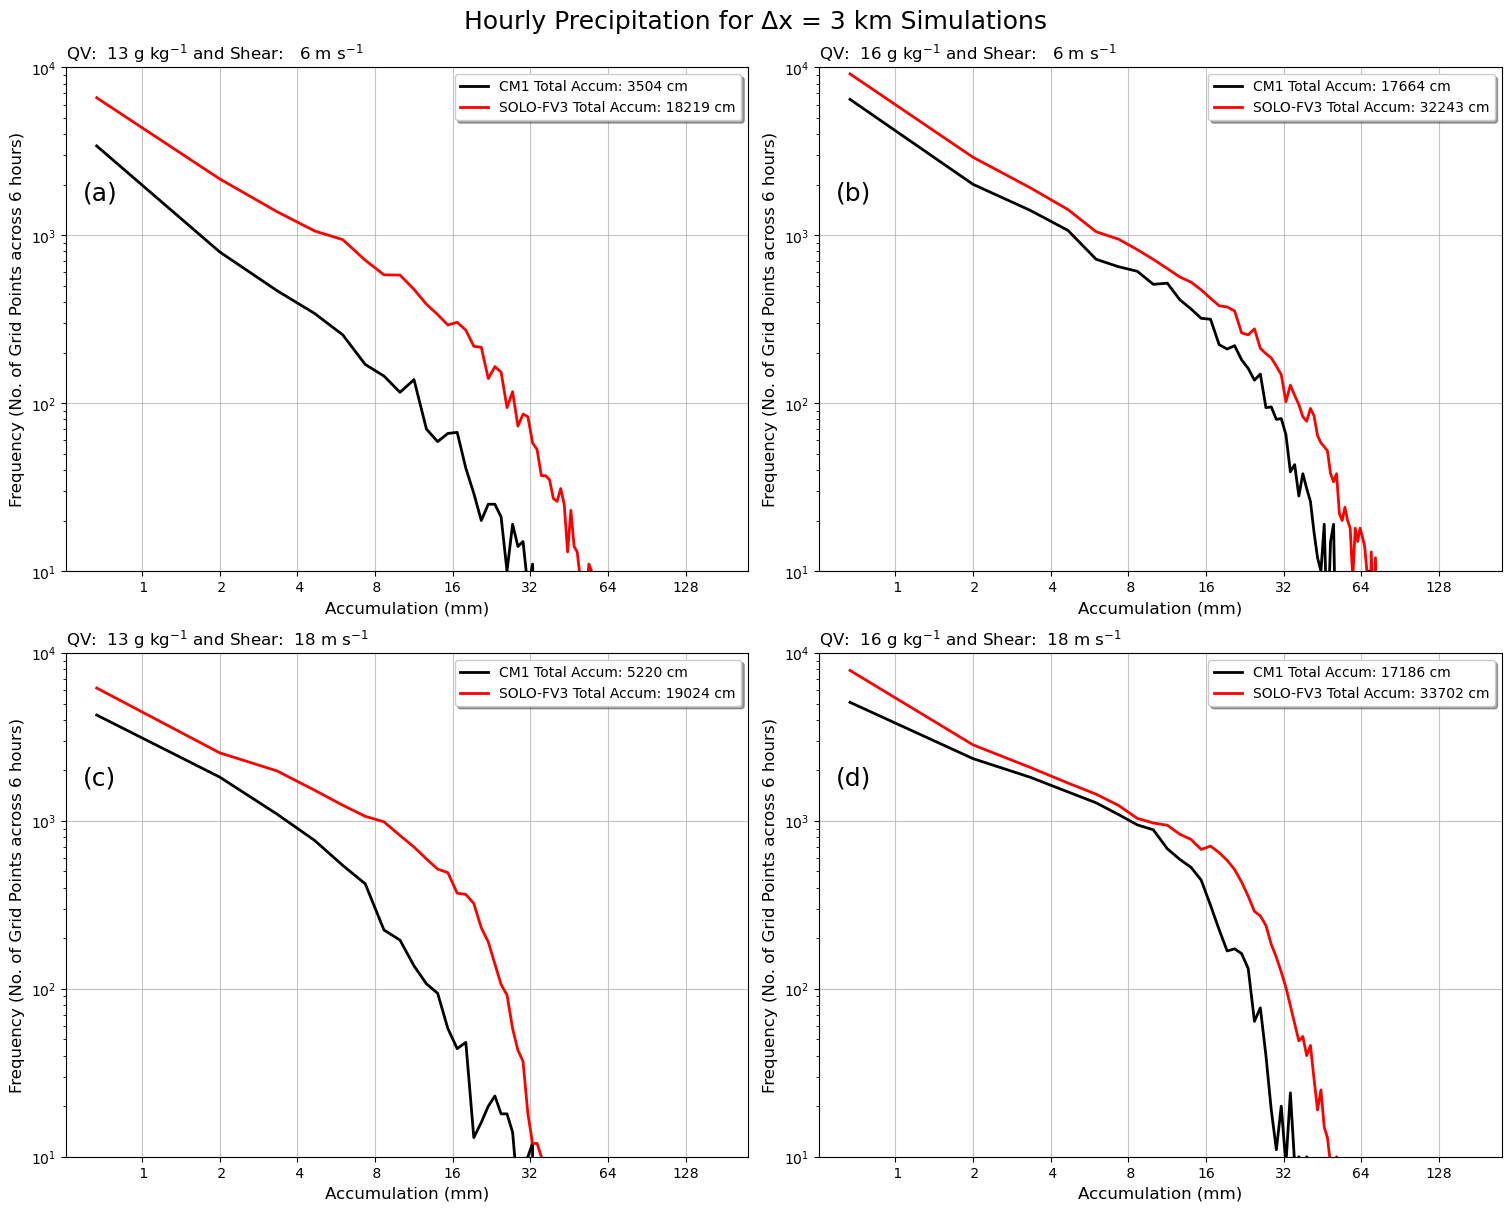

In [64]:
fig, ax = plt.subplots(2,2, constrained_layout=True,figsize=(15,12));

label2 = '3km'

ylim = [10., 10000.]
# label = f"'QV:  {} g kg$^{-1}$ and Shear:   {sh:2d} m s$^{-1}$"

precip_histogram(models3km, 'QV13/S06', 'QV:  13 g kg$^{-1}$ and Shear:   6 m s$^{-1}$', ylim=ylim, axs=ax[0,0])
precip_histogram(models3km, 'QV16/S06', 'QV:  16 g kg$^{-1}$ and Shear:   6 m s$^{-1}$', ylim=ylim, axs=ax[0,1])
precip_histogram(models3km, 'QV13/S18', 'QV:  13 g kg$^{-1}$ and Shear:  18 m s$^{-1}$', ylim=ylim, axs=ax[1,0])
precip_histogram(models3km, 'QV16/S18', 'QV:  16 g kg$^{-1}$ and Shear:  18 m s$^{-1}$', ylim=ylim, axs=ax[1,1])

ax = label_panels(ax, ['(a)', '(b)', '(c)', '(d)'], fontsize=18, adjust_loc=[0.0, -0.2])

plt.suptitle("Hourly Precipitation for \u0394x = 3 km Simulations", fontsize=18)
plt.savefig("./Figures/Histogram_1HR_Precipitation_{label2}.pdf")


In [46]:
models1km = {}

models1km['cm1']   = pickle2Obj(cm1_1km,retObj=False)
models1km['euler'] = pickle2Obj(euler_1km,retObj=False)

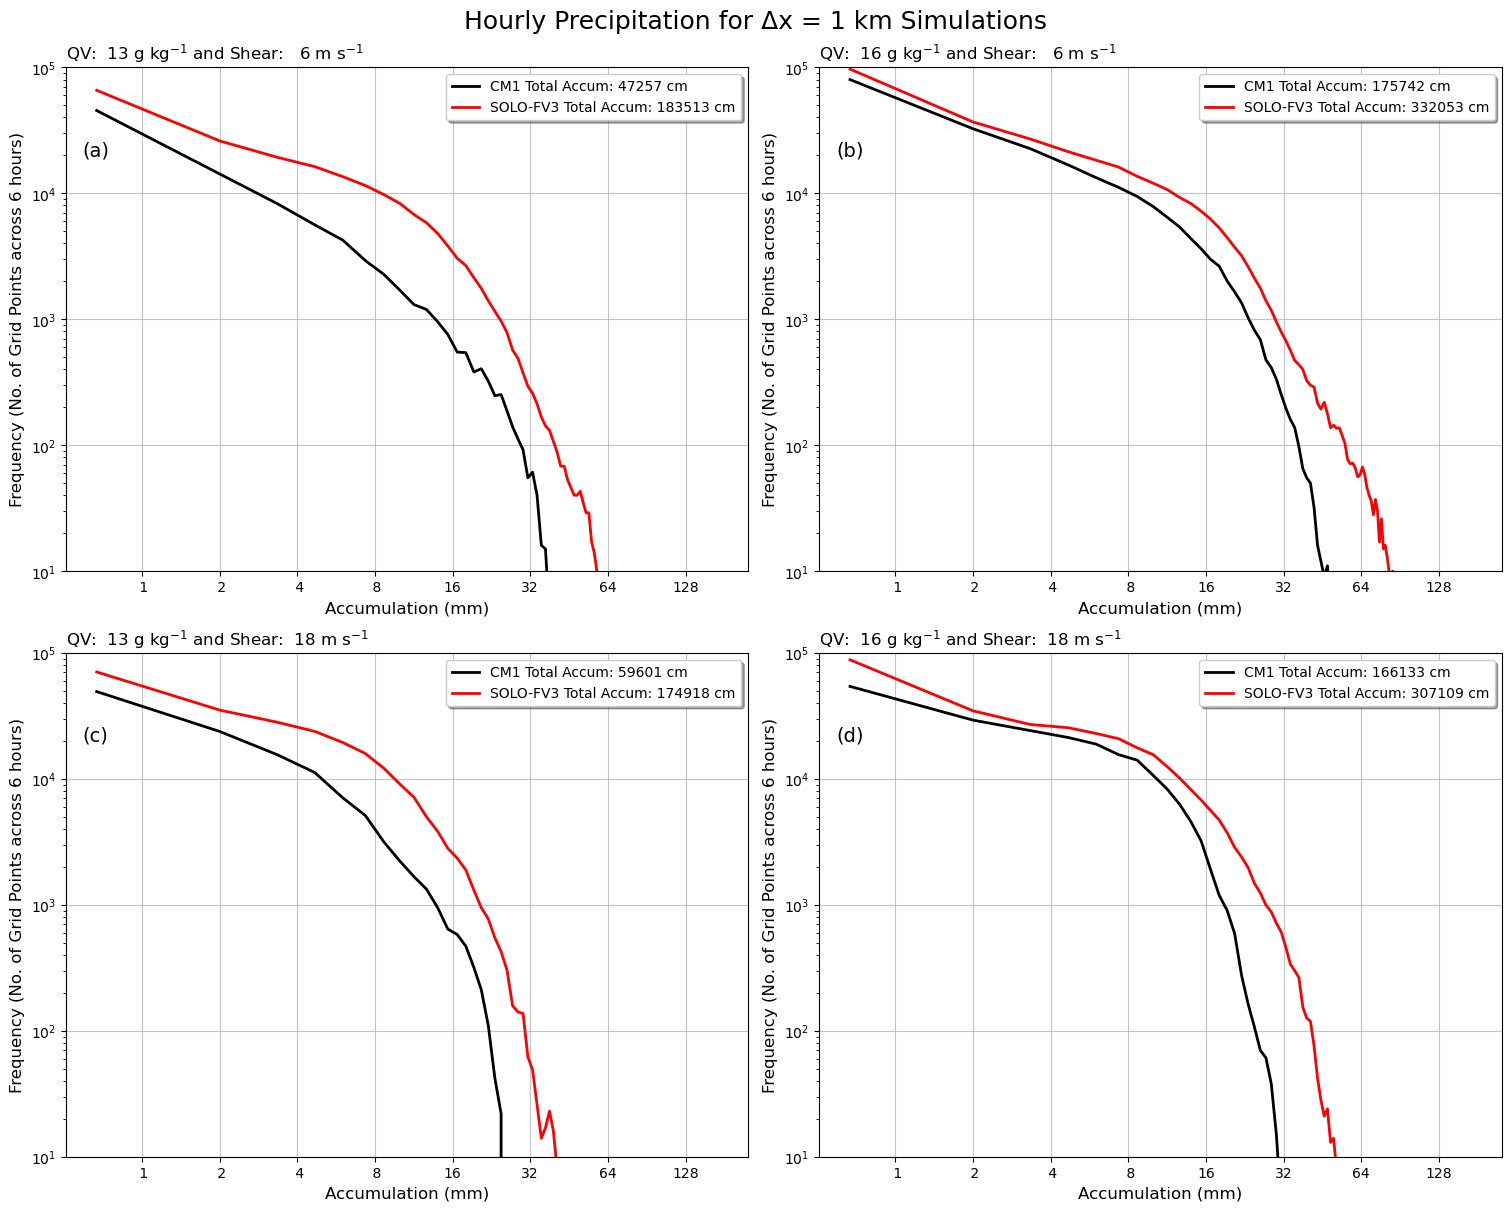

In [66]:
fig, ax = plt.subplots(2,2, constrained_layout=True,figsize=(15,12));

label2 = '1_KM'

ylim = [10., 100000.]
# label = f"'QV:  {} g kg$^{-1}$ and Shear:   {sh:2d} m s$^{-1}$"

precip_histogram(models1km, 'QV13/S06', 'QV:  13 g kg$^{-1}$ and Shear:   6 m s$^{-1}$', ylim=ylim, axs=ax[0,0])
precip_histogram(models1km, 'QV16/S06', 'QV:  16 g kg$^{-1}$ and Shear:   6 m s$^{-1}$', ylim=ylim, axs=ax[0,1])
precip_histogram(models1km, 'QV13/S18', 'QV:  13 g kg$^{-1}$ and Shear:  18 m s$^{-1}$', ylim=ylim, axs=ax[1,0])
precip_histogram(models1km, 'QV16/S18', 'QV:  16 g kg$^{-1}$ and Shear:  18 m s$^{-1}$', ylim=ylim, axs=ax[1,1])

ax = label_panels(ax, ['(a)', '(b)', '(c)', '(d)'], adjust_loc=[0.0, -0.12])

plt.suptitle("Hourly Precipitation for \u0394x = 1 km Simulations", fontsize=18)
plt.savefig(f"./Figures/Histogram_1HR_Precipitation_1km.pdf")



In [16]:
from scipy.stats import gaussian_kde

from sklearn.neighbors import KernelDensity

def precip_histogramAGG(models):
    
    fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(7,7))
    
    xlim = [0.01, 75.]

    labels =   ['C2000_06',
                'C2500_06',
                'C3000_06',
                'C3500_06',
                'C2000_12',
                'C2500_12',
                'C3000_12',
                'C3500_12',
                'C2000_18',
                'C2500_18',
                'C3000_18',
                'C3500_18']
    
    for key in models.keys():
            
    # first, compute hourly precip

        index = 0

        for label in labels:
                
            inv = models[key][label]['accum_prec'][::-1]

            precip = inv[0:-1] - inv[1:]

            for n in np.arange(6):
                m = n * 4
                precip_hour = precip[m] + precip[m+1] +precip[m+2] +precip[m+3]

            if index == 0:
                precip_dt = precip_hour.flatten()
            else:
                precip_dt = np.append(precip_dt, precip_hour.flatten())
                
            index += 1
    
        # get rid of zeros...
    
        data_flat = precip_dt.flatten()
        
        data_no_zero = data_flat[data_flat >= 1.0e-1]

        print(data_no_zero.shape)

        
        hist, bin_edges = np.histogram(data_no_zero)

        eval_points = np.linspace(np.min(bin_edges), np.max(bin_edges))
        kde_sp      = gaussian_kde(data_no_zero, bw_method=0.5)
        y_sp        = kde_sp.pdf(eval_points)
        
        if key == 'solo':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='SOLO (%d)' % data_no_zero.shape)
            
        if key == 'solo_hdd012':
            ax.plot(eval_points, y_sp, color='darkred', linewidth=2.0, linestyle=':', label='SOLO-D012 (%d)' % data_no_zero.shape)
        
        if key == 'solo_hdd125':
            ax.plot(eval_points, y_sp, color='red', linewidth=2.0, linestyle='solid', label='SOLO-D125 (%d)' % data_no_zero.shape)

        if key == 'wrf-5':
            ax.plot(eval_points, y_sp, color='k', linewidth=2.0, label='WRF (%d)' % data_no_zero.shape)
        
        if key == 'wrf-4':
            ax.plot(eval_points, y_sp, color='k', linewidth=1.0, label='WRF (%d)' % data_no_zero.shape)
            
        if key == 'cm1-5':
            ax.plot(eval_points, y_sp, color='b', linewidth=2.0, label='CM1 (%d)' % data_no_zero.shape)

        if key == 'cm1-4':
            ax.plot(eval_points, y_sp, color='b', linewidth=1.0, label='CM1 (%d)' % data_no_zero.shape)

        if key == 'mpas':
            ax.plot(eval_points, y_sp, color='r', linewidth=2.0, label='MPAS (%d)' % data_no_zero.shape)

        if key == 'mpas-wof':
            ax.plot(eval_points, y_sp, color='g', linewidth=2.0, label='MPAS-WOF (%d)' % data_no_zero.shape)
 
        ax.set_xlim(xlim[:])
        ax.set_yscale("log")
    #    ax.set_xscale("log", base=2.0)
        plt.grid(axis='y', alpha=0.75)
        plt.grid(axis='x', alpha=0.75)
        ax.set_xlabel('mm',fontsize=15)
        ax.set_ylabel('Density',fontsize=15)
        legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
        ax.axvline(x=40.0, color='k', linestyle='--', linewidth=2.0)
        ax.axvline(x=20.0, color='k', linestyle='--', linewidth=2.0)
        ax.set_title('KDE of Hourly Accumulated Precipitation All Experiments', fontsize=15)
        plt.savefig("KDE_Hourly_Accumulated_Precipitation_KDE_Experiment_%s.png" % ('ALL'))

    plt.show()
    


(6133,)
(5420,)
(6233,)
(6014,)


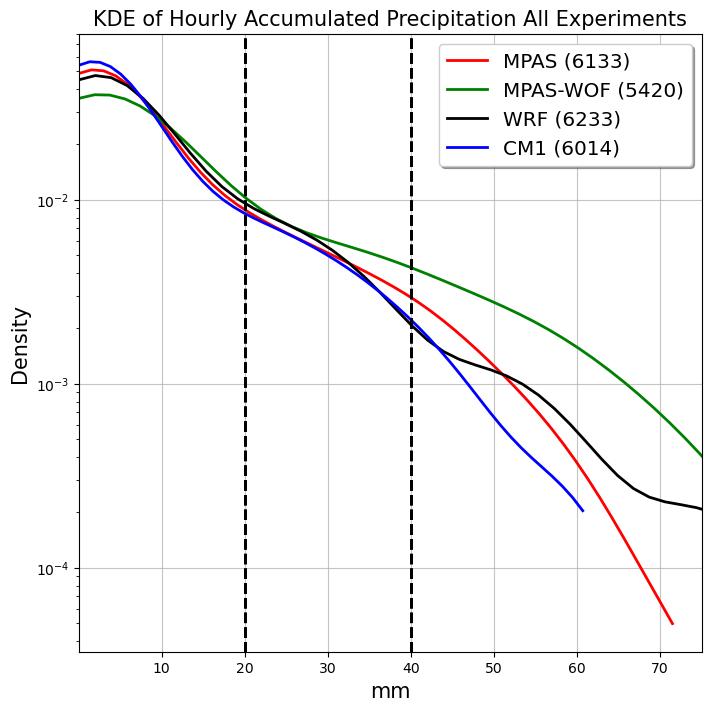

In [17]:
precip_histogramAGG(models1)